In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('vocab', '/home/gezi/temp/textsum/tfrecord/seq-basic.10w/train/vocab.txt', 'vocabulary file')

import sys, os, math
import gezi, melt
import numpy as np

from deepiu.util import text2ids

try:
    import conf  
    from conf import TEXT_MAX_WORDS, INPUT_TEXT_MAX_WORDS
except Exception:
    TEXT_MAX_WORDS = 20
    INPUT_TEXT_MAX_WORDS = 20
    
decode_max_words = 10

tensorflow_version: 1.1.0-rc0


In [3]:
def _text2ids(text, max_words):
  word_ids = text2ids.text2ids(text, 
                               seg_method='basic', 
                               feed_single=True, 
                               allow_all_zero=True, 
                               pad=False)
  #word_ids.append(text2ids.vocab.end_id())
  word_ids = word_ids[:max_words]
  word_ids = gezi.pad(word_ids, max_words, 0)

  return word_ids

In [4]:
from libgezi import utf82gbk, gbk2utf8
def predict(predictor, input_text):
  input_text = utf82gbk(input_text)
  word_ids = _text2ids(input_text, INPUT_TEXT_MAX_WORDS)
  print('word_ids', word_ids, 'len:', len(word_ids))
  print(gbk2utf8(text2ids.ids2text(word_ids)))

  timer = gezi.Timer()
  init_states = predictor.inference([
                                        'beam_search_beam_size',
                                        'beam_search_initial_state', 
                                        'beam_search_initial_ids', 
                                        'beam_search_initial_logprobs',
                                        'beam_search_initial_alignments'
                                        ], 
                                        feed_dict= {
                                          tf.get_collection('input_text_feed')[0] : [word_ids]
                                        })

  step_func = lambda input_feed, state_feed : predictor.inference([
                                        'beam_search_state', 
                                        'beam_search_ids', 
                                        'beam_search_logprobs',
                                        'beam_search_alignments', 
                                        ], 
                                        feed_dict= {
                                          #TODO...attetion still need input_text feed, see rnn_decoder.py  beam_search_step
                                          #but not hurt perfomance much because encoder is fast? Is it possible to avoid this?
                                          #anyway if no attention  will not need input_text_feed
                                          tf.get_collection('input_text_feed')[0] : [word_ids],
                                          tf.get_collection('beam_search_input_feed')[0] : input_feed,
                                          tf.get_collection('beam_search_state_feed')[0] : state_feed
                                        })

  max_words = decode_max_words if decode_max_words else TEXT_MAX_WORDS
  beams = melt.seq2seq.beam_search(init_states, 
                                   step_func, 
                                   end_id=text2ids.end_id(), 
                                   max_words=max_words, 
                                   length_normalization_factor=0.)

  #print(len(beams))
  #x_labels = [gbk2utf8(text2ids.vocab.key(x)).encode('utf8') for x in word_ids]
  for i, beam in enumerate(beams):
    print(gbk2utf8(text2ids.ids2text(word_ids)))
    print(i, beam.words, gbk2utf8(text2ids.ids2text(beam.words)), math.exp(beam.logprob), beam.logprob, beam.score, beam.logprobs)
    #print(beam.alignments_list)

    #plt.matshow(beam.alignments_list)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(beam.alignments_list, interpolation='nearest')
    #fig.colorbar(cax)

    #ax.set_xticklabels(['']+x_labels)
    #ax.set_yticklabels(['']+alpha)

    plt.show()


  print('beam search using time(ms):', timer.elapsed_ms())

In [5]:
print(FLAGS.vocab)

/home/gezi/temp/textsum/tfrecord/seq-basic.10w/train/vocab.txt


In [6]:
text2ids.init(FLAGS.vocab)
#model_dir='/home/gezi/temp/textsum/model.seq2seq.attention.encode_end/'
model_dir='/home/gezi/temp/textsum/model.seq2seq.attention'
predictor = melt.Predictor(model_dir)

def inference(text):
  predict(predictor, text)

ENCODE_UNK 1
restore from /home/gezi/temp/textsum/model.seq2seq.attention/model.ckpt-799001


INFO:tensorflow:Restoring parameters from /home/gezi/temp/textsum/model.seq2seq.attention/model.ckpt-799001


import graph ok /home/gezi/temp/textsum/model.seq2seq.attention/model.ckpt-799001.meta
restore ok /home/gezi/temp/textsum/model.seq2seq.attention/model.ckpt-799001


In [7]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

word_ids [5572, 8145, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
排行/网游
排行/网游
0 [8145, 2] 网游/<EOS> 0.000325124163921 -8.0313 -8.0313 [-4.9920802, -3.0392234]


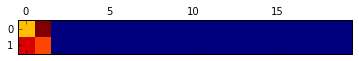

排行/网游
1 [5572, 2] 排行/<EOS> 0.00013028061529 -8.94582 -8.94582 [-6.757153, -2.1886673]


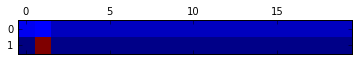

排行/网游
2 [8145, 5572, 2] 网游/排行/<EOS> 5.26132337743e-05 -9.85254 -9.85254 [-4.9920802, -3.8845651, -0.97589803]


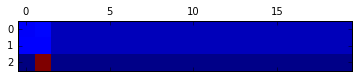

排行/网游
3 [8145, 8145, 2] 网游/网游/<EOS> 2.09935049782e-05 -10.7713 -10.7713 [-4.9920802, -4.971117, -0.80809933]


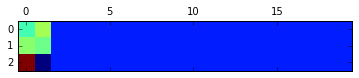

排行/网游
4 [5572, 5572, 2] 排行/排行/<EOS> 4.96833774307e-06 -12.2124 -12.2124 [-6.757153, -4.7874641, -0.66780901]


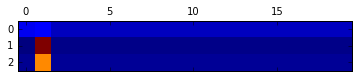

排行/网游
5 [5572, 8145, 2] 排行/网游/<EOS> 6.19281225832e-07 -14.2947 -14.2947 [-6.757153, -6.9380388, -0.59951395]


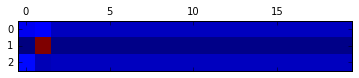

排行/网游
6 [8145, 8145, 5572, 2] 网游/网游/排行/<EOS> 3.40718879703e-07 -14.8922 -14.8922 [-4.9920802, -4.971117, -4.3201613, -0.60884881]


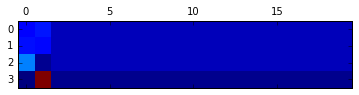

排行/网游
7 [8145, 5572, 5572, 2] 网游/排行/排行/<EOS> 2.05332563642e-07 -15.3986 -15.3986 [-4.9920802, -3.8845651, -6.0162287, -0.50576109]


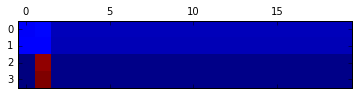

排行/网游
8 [8145, 8145, 8145, 2] 网游/网游/网游/<EOS> 3.8173316968e-08 -17.0811 -17.0811 [-4.9920802, -4.971117, -6.5764585, -0.54147297]


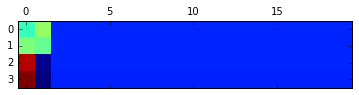

排行/网游
9 [8145, 5572, 8145, 2] 网游/排行/网游/<EOS> 1.65891902804e-08 -17.9145 -17.9145 [-4.9920802, -3.8845651, -8.7205009, -0.31737021]


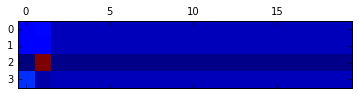

beam search using time(ms): 1581.66599274


In [12]:
inference('排行网游')

word_ids [54, 25878, 23374, 1237, 441, 194, 979, 156, 215, 116, 15349, 949, 2836, 0, 0, 0, 0, 0, 0, 0] len: 20
上/外教/口语/课/能/在/1/个/月/内/提高/吗/?
上/外教/口语/课/能/在/1/个/月/内/提高/吗/?
0 [25878, 2] 外教/<EOS> 0.00693314168719 -4.97144 -4.97144 [-3.0489364, -1.9225059]


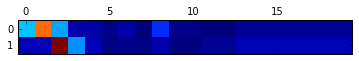

上/外教/口语/课/能/在/1/个/月/内/提高/吗/?
1 [54, 25878, 2] 上/外教/<EOS> 0.00387625602823 -5.55289 -5.55289 [-2.9559741, -1.6137921, -0.98311961]


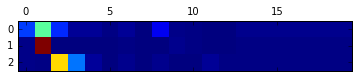

上/外教/口语/课/能/在/1/个/月/内/提高/吗/?
2 [25878, 25878, 2] 外教/外教/<EOS> 0.00125704888901 -6.67899 -6.67899 [-3.0489364, -3.2683549, -0.36169717]


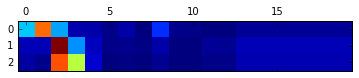

上/外教/口语/课/能/在/1/个/月/内/提高/吗/?
3 [23374, 2] 口语/<EOS> 0.00120976861583 -6.71733 -6.71733 [-4.3214498, -2.3958764]


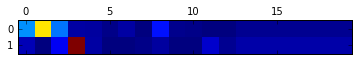

上/外教/口语/课/能/在/1/个/月/内/提高/吗/?
4 [23374, 1237, 2] 口语/课/<EOS> 0.00110357509066 -6.8092 -6.8092 [-4.3214498, -1.9792827, -0.50846756]


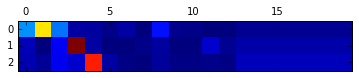

上/外教/口语/课/能/在/1/个/月/内/提高/吗/?
5 [25878, 23374, 2] 外教/口语/<EOS> 0.00035828162208 -7.93419 -7.93419 [-3.0489364, -3.687057, -1.1981977]


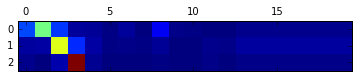

上/外教/口语/课/能/在/1/个/月/内/提高/吗/?
6 [54, 25878, 25878, 2] 上/外教/外教/<EOS> 0.000271435430983 -8.21179 -8.21179 [-2.9559741, -1.6137921, -3.2283988, -0.41362175]


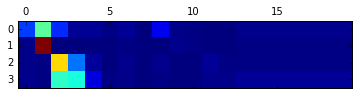

上/外教/口语/课/能/在/1/个/月/内/提高/吗/?
7 [25878, 23374, 1237, 2] 外教/口语/课/<EOS> 0.000200224691223 -8.51607 -8.51607 [-3.0489364, -3.687057, -1.48673, -0.29334775]


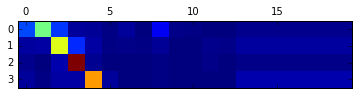

上/外教/口语/课/能/在/1/个/月/内/提高/吗/?
8 [25878, 1237, 2] 外教/课/<EOS> 0.000175949883628 -8.64531 -8.64531 [-3.0489364, -5.0633779, -0.53299719]


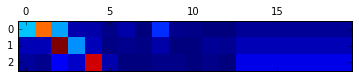

上/外教/口语/课/能/在/1/个/月/内/提高/吗/?
9 [1237, 2] 课/<EOS> 0.000161419119684 -8.73151 -8.73151 [-5.4090638, -3.3224425]


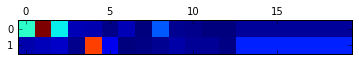

beam search using time(ms): 1570.17397881
word_ids [6595, 4165, 95, 294, 210, 7213, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
土豪/邹/红/建/是/阿拉斯加
土豪/邹/红/建/是/阿拉斯加
0 [95, 294, 2] 红/建/<EOS> 0.0087600088403 -4.73756 -4.73756 [-2.8609803, -1.258956, -0.61762214]


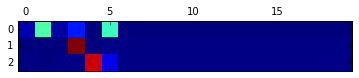

土豪/邹/红/建/是/阿拉斯加
1 [7213, 2] 阿拉斯加/<EOS> 0.00313181115244 -5.76614 -5.76614 [-3.1805041, -2.5856395]


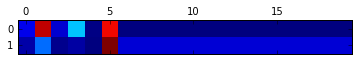

土豪/邹/红/建/是/阿拉斯加
2 [6595, 2] 土豪/<EOS> 0.00198537554134 -6.22195 -6.22195 [-3.7343018, -2.4876454]


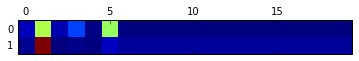

土豪/邹/红/建/是/阿拉斯加
3 [7213, 7213, 2] 阿拉斯加/阿拉斯加/<EOS> 0.00108308028024 -6.82795 -6.82795 [-3.1805041, -3.0128961, -0.63454586]


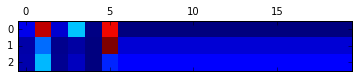

土豪/邹/红/建/是/阿拉斯加
4 [95, 294, 210, 7213, 2] 红/建/是/阿拉斯加/<EOS> 0.000516211965188 -7.56899 -7.56899 [-2.8609803, -1.258956, -2.753123, -0.33688128, -0.35905254]


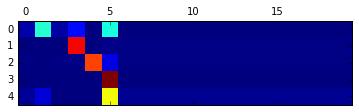

土豪/邹/红/建/是/阿拉斯加
5 [95, 7213, 2] 红/阿拉斯加/<EOS> 0.000485657329057 -7.63001 -7.63001 [-2.8609803, -4.1348047, -0.63422233]


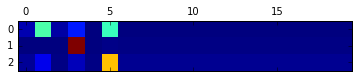

土豪/邹/红/建/是/阿拉斯加
6 [6595, 6595, 2] 土豪/土豪/<EOS> 0.000273913098332 -8.2027 -8.2027 [-3.7343018, -3.6817267, -0.78667104]


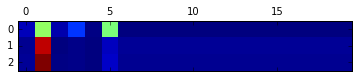

土豪/邹/红/建/是/阿拉斯加
7 [6595, 95, 2] 土豪/红/<EOS> 0.000243734202948 -8.31943 -8.31943 [-3.7343018, -3.454962, -1.1301687]


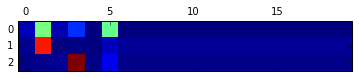

土豪/邹/红/建/是/阿拉斯加
8 [7213, 95, 2] 阿拉斯加/红/<EOS> 0.000240552321994 -8.33257 -8.33257 [-3.1805041, -4.2796588, -0.87240946]


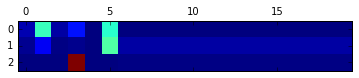

土豪/邹/红/建/是/阿拉斯加
9 [4165, 95, 2] 邹/红/<EOS> 0.000218312595964 -8.42958 -8.42958 [-7.0728683, -0.13619068, -1.2205237]


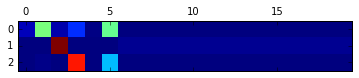

beam search using time(ms): 1508.62312317
word_ids [602, 6734, 14069, 412, 869, 1474, 363, 77846, 164, 926, 649, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
韩国/棒球/啦啦队/员/朴/姬/兰/神似/刘/亦/菲
韩国/棒球/啦啦队/员/朴/姬/兰/神似/刘/亦/菲
0 [602, 6734, 14069, 2] 韩国/棒球/啦啦队/<EOS> 0.043906450368 -3.12569 -3.12569 [-0.38195348, -0.67562574, -1.5571343, -0.51098031]


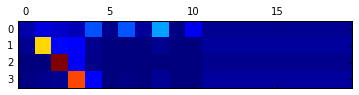

韩国/棒球/啦啦队/员/朴/姬/兰/神似/刘/亦/菲
1 [602, 6734, 2] 韩国/棒球/<EOS> 0.0420047263455 -3.16997 -3.16997 [-0.38195348, -0.67562574, -2.1123939]


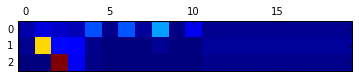

韩国/棒球/啦啦队/员/朴/姬/兰/神似/刘/亦/菲
2 [869, 1474, 2] 朴/姬/<EOS> 0.012292053523 -4.3988 -4.3988 [-2.0554354, -0.40661609, -1.9367508]


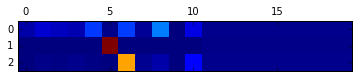

韩国/棒球/啦啦队/员/朴/姬/兰/神似/刘/亦/菲
3 [164, 926, 649, 2] 刘/亦/菲/<EOS> 0.00512405116405 -5.27381 -5.27381 [-2.9059212, -0.023030071, -0.0021547689, -2.3427038]


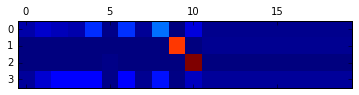

韩国/棒球/啦啦队/员/朴/姬/兰/神似/刘/亦/菲
4 [869, 1474, 363, 2] 朴/姬/兰/<EOS> 0.00431759632233 -5.44506 -5.44506 [-2.0554354, -0.40661609, -2.3515019, -0.63150328]


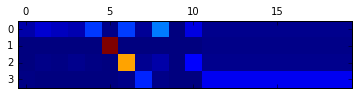

韩国/棒球/啦啦队/员/朴/姬/兰/神似/刘/亦/菲
5 [602, 6734, 6734, 2] 韩国/棒球/棒球/<EOS> 0.002737578535 -5.90068 -5.90068 [-0.38195348, -0.67562574, -3.7039304, -1.1391715]


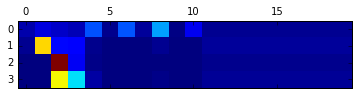

韩国/棒球/啦啦队/员/朴/姬/兰/神似/刘/亦/菲
6 [602, 14069, 2] 韩国/啦啦队/<EOS> 0.00265180139554 -5.93252 -5.93252 [-0.38195348, -4.7041159, -0.84644693]


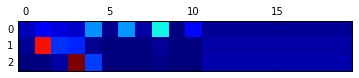

韩国/棒球/啦啦队/员/朴/姬/兰/神似/刘/亦/菲
7 [602, 869, 1474, 2] 韩国/朴/姬/<EOS> 0.001451918935 -6.53487 -6.53487 [-0.38195348, -4.8466654, -0.48239863, -0.82385182]


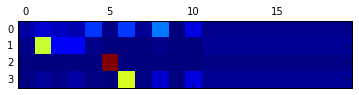

韩国/棒球/啦啦队/员/朴/姬/兰/神似/刘/亦/菲
8 [6734, 14069, 2] 棒球/啦啦队/<EOS> 0.00113733169634 -6.77907 -6.77907 [-4.1877451, -1.6205955, -0.97072983]


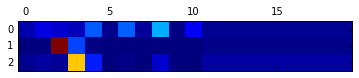

韩国/棒球/啦啦队/员/朴/姬/兰/神似/刘/亦/菲
9 [869, 1474, 602, 2] 朴/姬/韩国/<EOS> 0.00101211233279 -6.89572 -6.89572 [-2.0554354, -0.40661609, -3.6569495, -0.77671474]


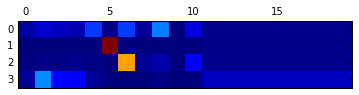

beam search using time(ms): 1741.53399467
word_ids [214, 899, 322, 1866, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
你/去/打/篮球
你/去/打/篮球
0 [322, 1866, 2] 打/篮球/<EOS> 0.0528932477806 -2.93948 -2.93948 [-0.84278071, -0.012763594, -2.0839353]


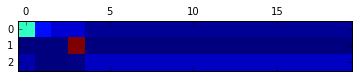

你/去/打/篮球
1 [1866, 322, 1866, 2] 篮球/打/篮球/<EOS> 0.0122138497491 -4.40518 -4.40518 [-1.686072, -1.6890986, -0.025248008, -1.004766]


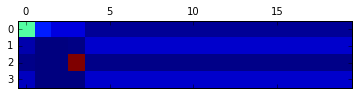

你/去/打/篮球
2 [322, 1866, 322, 1866, 2] 打/篮球/打/篮球/<EOS> 0.00185366719842 -6.29059 -6.29059 [-0.84278071, -0.012763594, -4.2566762, -0.087507389, -1.0908616]


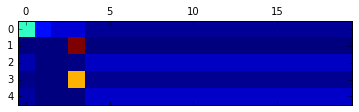

你/去/打/篮球
3 [1866, 2] 篮球/<EOS> 0.00170364985299 -6.37498 -6.37498 [-1.686072, -4.6889105]


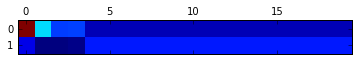

你/去/打/篮球
4 [1866, 1866, 2] 篮球/篮球/<EOS> 0.00138095102031 -6.58498 -6.58498 [-1.686072, -3.3385613, -1.5603496]


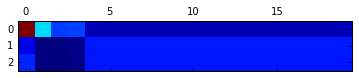

你/去/打/篮球
5 [214, 322, 1866, 2] 你/打/篮球/<EOS> 0.00125300939193 -6.68221 -6.68221 [-3.5981288, -1.4759697, -0.0073524364, -1.6007564]


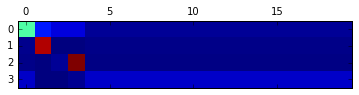

你/去/打/篮球
6 [214, 899, 322, 1866, 2] 你/去/打/篮球/<EOS> 0.000537185451759 -7.52917 -7.52917 [-3.5981288, -2.2092948, -0.061341751, -0.22201863, -1.4383832]


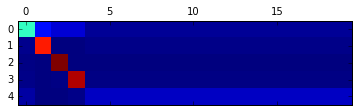

你/去/打/篮球
7 [322, 1866, 1866, 2] 打/篮球/篮球/<EOS> 0.000462120169921 -7.67969 -7.67969 [-0.84278071, -0.012763594, -5.6418853, -1.1822556]


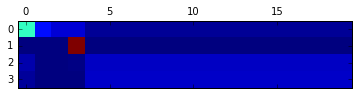

你/去/打/篮球
8 [322, 322, 1866, 2] 打/打/篮球/<EOS> 0.000461844806908 -7.68028 -7.68028 [-0.84278071, -5.3448958, -0.25568551, -1.2369201]


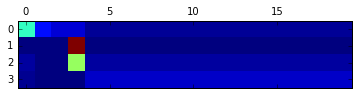

你/去/打/篮球
9 [899, 322, 1866, 2] 去/打/篮球/<EOS> 0.000235187087874 -8.35513 -8.35513 [-6.6614909, -0.025191749, -0.25384873, -1.4145982]


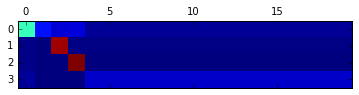

beam search using time(ms): 1519.49095726
word_ids [322, 1866, 214, 899, 949, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
打/篮球/你/去/吗
打/篮球/你/去/吗
0 [322, 1866, 2] 打/篮球/<EOS> 0.0567308988149 -2.86944 -2.86944 [-0.69512862, -0.0092917392, -2.1650159]


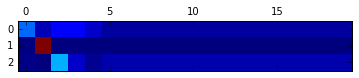

打/篮球/你/去/吗
1 [1866, 322, 1866, 2] 篮球/打/篮球/<EOS> 0.0259936670989 -3.6499 -3.6499 [-1.5005867, -1.107774, -0.022354985, -1.0191865]


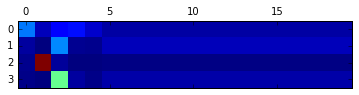

打/篮球/你/去/吗
2 [322, 1866, 322, 1866, 2] 打/篮球/打/篮球/<EOS> 0.0073658692719 -4.9109 -4.9109 [-0.69512862, -0.0092917392, -3.0970666, -0.075228065, -1.0341831]


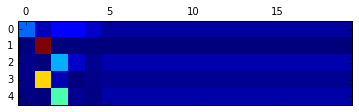

打/篮球/你/去/吗
3 [1866, 2] 篮球/<EOS> 0.00223218259777 -6.10478 -6.10478 [-1.5005867, -4.6041889]


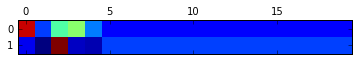

打/篮球/你/去/吗
4 [1866, 1866, 2] 篮球/篮球/<EOS> 0.00175486871214 -6.34536 -6.34536 [-1.5005867, -3.2482769, -1.5964974]


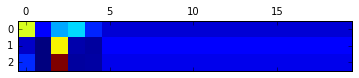

打/篮球/你/去/吗
5 [322, 1866, 1866, 2] 打/篮球/篮球/<EOS> 0.00104550075653 -6.86326 -6.86326 [-0.69512862, -0.0092917392, -5.0031443, -1.1556946]


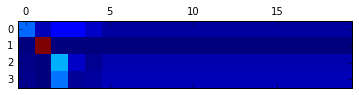

打/篮球/你/去/吗
6 [322, 322, 1866, 2] 打/打/篮球/<EOS> 0.000519152188234 -7.56331 -7.56331 [-0.69512862, -5.4941988, -0.16777541, -1.2062104]


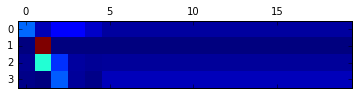

打/篮球/你/去/吗
7 [1866, 1866, 322, 1866, 2] 篮球/篮球/打/篮球/<EOS> 0.000410761130672 -7.7975 -7.7975 [-1.5005867, -3.2482769, -2.2810278, -0.029125361, -0.73848224]


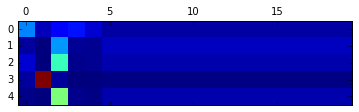

打/篮球/你/去/吗
8 [322, 1866, 214, 2] 打/篮球/你/<EOS> 0.000332912354649 -8.00763 -8.00763 [-0.69512862, -0.0092917392, -5.6252785, -1.6779324]


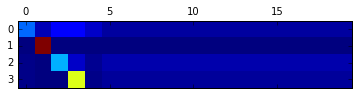

打/篮球/你/去/吗
9 [214, 322, 1866, 2] 你/打/篮球/<EOS> 0.000252983444489 -8.28219 -8.28219 [-5.4840279, -0.85103846, -0.0054194438, -1.9417008]


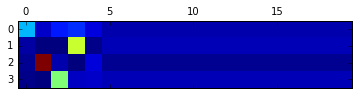

beam search using time(ms): 1591.46094322
word_ids [1492, 210, 267, 244, 655, 9, 22731, 80, 40621, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
这/是/周/华/健/的/新歌/爱/相随
这/是/周/华/健/的/新歌/爱/相随
0 [267, 244, 655, 2] 周/华/健/<EOS> 0.157286298607 -1.84969 -1.84969 [-0.24700384, -0.0205245, -0.036127459, -1.5460318]


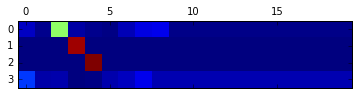

这/是/周/华/健/的/新歌/爱/相随
1 [267, 244, 655, 267, 244, 655, 2] 周/华/健/周/华/健/<EOS> 0.00416781695538 -5.48036 -5.48036 [-0.24700384, -0.0205245, -0.036127459, -4.5287066, -0.10594437, -0.018336898, -0.52371979]


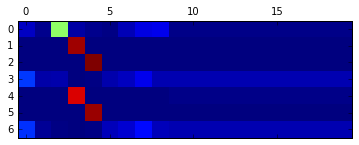

这/是/周/华/健/的/新歌/爱/相随
2 [267, 244, 2] 周/华/<EOS> 0.00358985338523 -5.62964 -5.62964 [-0.24700384, -0.0205245, -5.3621154]


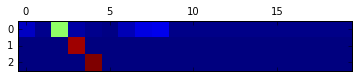

这/是/周/华/健/的/新歌/爱/相随
3 [267, 244, 655, 22731, 2] 周/华/健/新歌/<EOS> 0.000128148928468 -8.96232 -8.96232 [-0.24700384, -0.0205245, -0.036127459, -7.3175802, -1.341082]


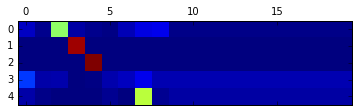

这/是/周/华/健/的/新歌/爱/相随
4 [267, 244, 655, 80, 2] 周/华/健/爱/<EOS> 0.000121220827841 -9.0179 -9.0179 [-0.24700384, -0.0205245, -0.036127459, -7.0091496, -1.7050914]


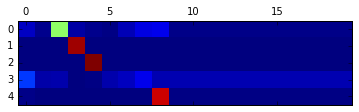

这/是/周/华/健/的/新歌/爱/相随
5 [267, 244, 655, 9, 2] 周/华/健/的/<EOS> 0.000120152859553 -9.02675 -9.02675 [-0.24700384, -0.0205245, -0.036127459, -3.4145412, -5.3085489]


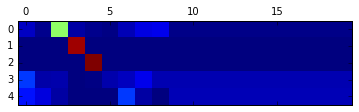

这/是/周/华/健/的/新歌/爱/相随
6 [267, 267, 244, 2] 周/周/华/<EOS> 7.37626557377e-05 -9.51466 -9.51466 [-0.24700384, -7.5297112, -0.80000049, -0.9379425]


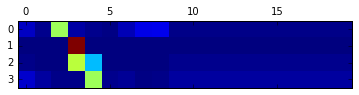

这/是/周/华/健/的/新歌/爱/相随
7 [267, 244, 655, 9, 267, 244, 655, 2] 周/华/健/的/周/华/健/<EOS> 6.23398922631e-05 -9.68291 -9.68291 [-0.24700384, -0.0205245, -0.036127459, -3.4145412, -5.3986044, -0.035208352, -0.05823129, -0.4726674]


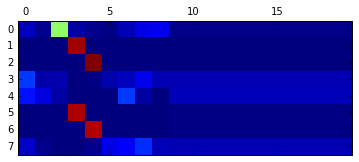

这/是/周/华/健/的/新歌/爱/相随
8 [267, 244, 267, 2] 周/华/周/<EOS> 5.18039139222e-05 -9.86804 -9.86804 [-0.24700384, -0.0205245, -8.1185169, -1.4819993]


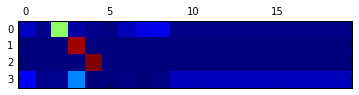

这/是/周/华/健/的/新歌/爱/相随
9 [267, 244, 655, 9, 80, 2] 周/华/健/的/爱/<EOS> 4.0047037536e-05 -10.1255 -10.1255 [-0.24700384, -0.0205245, -0.036127459, -3.4145412, -5.2967024, -1.1105567]


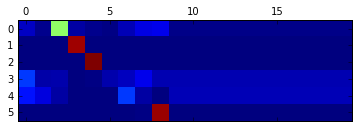

beam search using time(ms): 1650.94089508
word_ids [37, 14356, 8, 16948, 1513, 1481, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
美女/劈叉/ /鼻血/狂/喷
美女/劈叉/ /鼻血/狂/喷
0 [37, 14356, 2] 美女/劈叉/<EOS> 0.0196256670788 -3.93092 -3.93092 [-0.8996017, -2.5538869, -0.47742844]


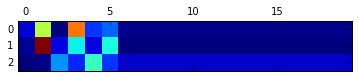

美女/劈叉/ /鼻血/狂/喷
1 [14356, 2] 劈叉/<EOS> 0.00405746685922 -5.5072 -5.5072 [-4.2873621, -1.2198346]


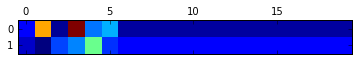

美女/劈叉/ /鼻血/狂/喷
2 [37, 2] 美女/<EOS> 0.00218261704194 -6.12723 -6.12723 [-0.8996017, -5.2276292]


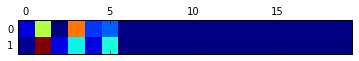

美女/劈叉/ /鼻血/狂/喷
3 [14356, 37, 2] 劈叉/美女/<EOS> 0.00210130258227 -6.1652 -6.1652 [-4.2873621, -1.6438353, -0.23400082]


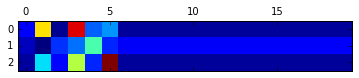

美女/劈叉/ /鼻血/狂/喷
4 [37, 8, 14356, 2] 美女/ /劈叉/<EOS> 0.000701958510756 -7.26164 -7.26164 [-0.8996017, -2.7703147, -3.3784285, -0.21329169]


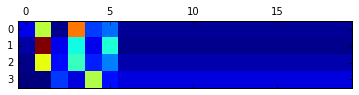

美女/劈叉/ /鼻血/狂/喷
5 [14356, 8, 37, 2] 劈叉/ /美女/<EOS> 0.000370736257018 -7.90002 -7.90002 [-4.2873621, -2.5635216, -0.84918535, -0.19995081]


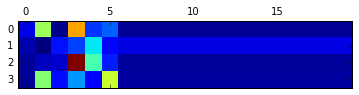

美女/劈叉/ /鼻血/狂/喷
6 [16948, 2] 鼻血/<EOS> 0.000203597642404 -8.49936 -8.49936 [-7.1046829, -1.3946815]


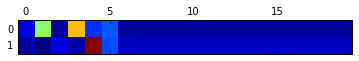

美女/劈叉/ /鼻血/狂/喷
7 [37, 16948, 2] 美女/鼻血/<EOS> 0.00012431273468 -8.99271 -8.99271 [-0.8996017, -7.5299392, -0.563169]


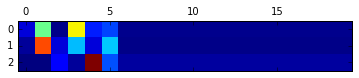

美女/劈叉/ /鼻血/狂/喷
8 [16948, 37, 2] 鼻血/美女/<EOS> 0.000119132127385 -9.03528 -9.03528 [-7.1046829, -1.7167335, -0.21386035]


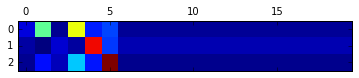

美女/劈叉/ /鼻血/狂/喷
9 [37, 37, 14356, 2] 美女/美女/劈叉/<EOS> 3.91826356133e-05 -10.1473 -10.1473 [-0.8996017, -6.0153108, -2.751102, -0.48126304]


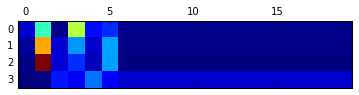

beam search using time(ms): 1602.03194618
word_ids [8246, 9974, 1298, 426, 775, 448, 2238, 1800, 88, 2340, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)
蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)
0 [1298, 426, 775, 448, 2] 赵丽/颖/古装/剧照/<EOS> 0.0370360811713 -3.29586 -3.29586 [-0.17846051, -0.00055798219, -1.4610814, -1.1474153, -0.50834751]


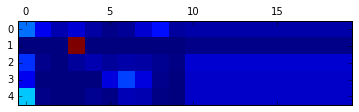

蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)
1 [1298, 426, 8246, 9974, 448, 2] 赵丽/颖/蜀山/战纪/剧照/<EOS> 0.0211887629682 -3.85428 -3.85428 [-0.17846051, -0.00055798219, -2.3058529, -0.047916785, -1.1201861, -0.20130992]


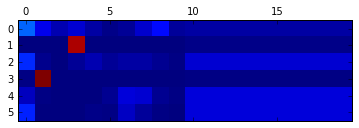

蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)
2 [1298, 426, 775, 2] 赵丽/颖/古装/<EOS> 0.00934527450229 -4.67288 -4.67288 [-0.17846051, -0.00055798219, -1.4610814, -3.0327845]


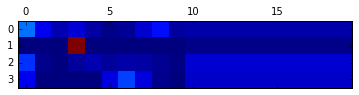

蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)
3 [1298, 426, 8246, 9974, 2] 赵丽/颖/蜀山/战纪/<EOS> 0.00703308080631 -4.95713 -4.95713 [-0.17846051, -0.00055798219, -2.3058529, -0.047916785, -2.4243424]


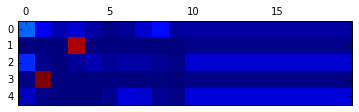

蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)
4 [8246, 9974, 1298, 426, 448, 2] 蜀山/战纪/赵丽/颖/剧照/<EOS> 0.00501412442631 -5.2955 -5.2955 [-2.5182891, -0.019557966, -1.1182745, -0.0014019909, -1.482973, -0.15500021]


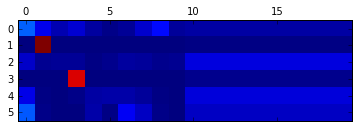

蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)
5 [1298, 426, 2] 赵丽/颖/<EOS> 0.00493461785224 -5.31148 -5.31148 [-0.17846051, -0.00055798219, -5.1324615]


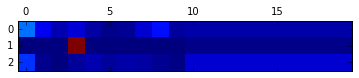

蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)
6 [8246, 9974, 448, 2] 蜀山/战纪/剧照/<EOS> 0.00461474552114 -5.3785 -5.3785 [-2.5182891, -0.019557966, -2.1833036, -0.65734816]


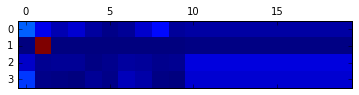

蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)
7 [1298, 426, 448, 2] 赵丽/颖/剧照/<EOS> 0.00447842443922 -5.40848 -5.40848 [-0.17846051, -0.00055798219, -3.6068401, -1.6226252]


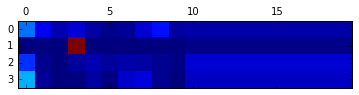

蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)
8 [8246, 9974, 2] 蜀山/战纪/<EOS> 0.00330038697153 -5.71372 -5.71372 [-2.5182891, -0.019557966, -3.1758687]


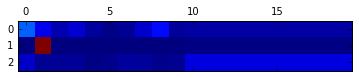

蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)
9 [1298, 426, 8246, 9974, 775, 2] 赵丽/颖/蜀山/战纪/古装/<EOS> 0.00318231642394 -5.75015 -5.75015 [-0.17846051, -0.00055798219, -2.3058529, -0.047916785, -2.4232829, -0.79407507]


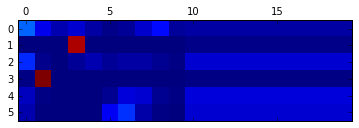

beam search using time(ms): 1667.09399223
word_ids [6023, 4066, 768, 31, 72399, 8, 16787, 613, 1324, 9, 5780, 4066, 102, 770, 0, 0, 0, 0, 0, 0] len: 20
成龙/定制/豪/车/领衔/ /盘点/明星/们/的/奢华/定制/超/跑
成龙/定制/豪/车/领衔/ /盘点/明星/们/的/奢华/定制/超/跑
0 [613, 768, 31, 2] 明星/豪/车/<EOS> 0.0239242437971 -3.73286 -3.73286 [-1.834893, -1.0620767, -0.0075007002, -0.82839262]


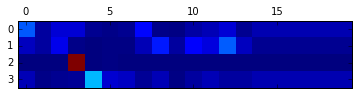

成龙/定制/豪/车/领衔/ /盘点/明星/们/的/奢华/定制/超/跑
1 [768, 31, 2] 豪/车/<EOS> 0.0118924290648 -4.43185 -4.43185 [-2.2747724, -0.010566243, -2.1465149]


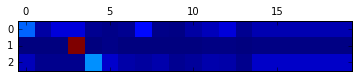

成龙/定制/豪/车/领衔/ /盘点/明星/们/的/奢华/定制/超/跑
2 [768, 31, 613, 2] 豪/车/明星/<EOS> 0.00635695617801 -5.05821 -5.05821 [-2.2747724, -0.010566243, -2.039753, -0.73311424]


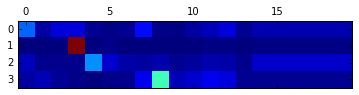

成龙/定制/豪/车/领衔/ /盘点/明星/们/的/奢华/定制/超/跑
3 [6023, 768, 31, 2] 成龙/豪/车/<EOS> 0.00398566685243 -5.52505 -5.52505 [-3.1645744, -1.8042212, -0.005954029, -0.5503006]


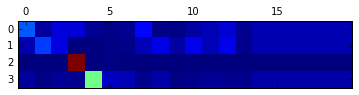

成龙/定制/豪/车/领衔/ /盘点/明星/们/的/奢华/定制/超/跑
4 [613, 8, 768, 31, 2] 明星/ /豪/车/<EOS> 0.00392890554697 -5.53939 -5.53939 [-1.834893, -3.0264568, -0.44985968, -0.0048628636, -0.22332197]


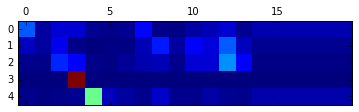

成龙/定制/豪/车/领衔/ /盘点/明星/们/的/奢华/定制/超/跑
5 [6023, 8, 768, 31, 2] 成龙/ /豪/车/<EOS> 0.00339424411085 -5.68567 -5.68567 [-3.1645744, -2.0187778, -0.38175973, -0.0039641857, -0.11659766]


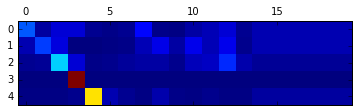

成龙/定制/豪/车/领衔/ /盘点/明星/们/的/奢华/定制/超/跑
6 [768, 31, 8, 613, 2] 豪/车/ /明星/<EOS> 0.00190413003523 -6.26373 -6.26373 [-2.2747724, -0.010566243, -2.1699448, -1.620901, -0.18754569]


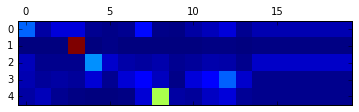

成龙/定制/豪/车/领衔/ /盘点/明星/们/的/奢华/定制/超/跑
7 [6023, 2] 成龙/<EOS> 0.00179443547686 -6.32306 -6.32306 [-3.1645744, -3.1584902]


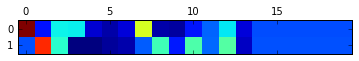

成龙/定制/豪/车/领衔/ /盘点/明星/们/的/奢华/定制/超/跑
8 [768, 31, 768, 31, 2] 豪/车/豪/车/<EOS> 0.00166966216042 -6.39513 -6.39513 [-2.2747724, -0.010566243, -3.4652119, -0.019774558, -0.62480932]


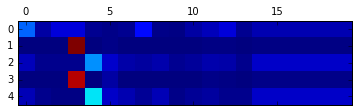

成龙/定制/豪/车/领衔/ /盘点/明星/们/的/奢华/定制/超/跑
9 [613, 613, 768, 31, 2] 明星/明星/豪/车/<EOS> 0.00122350671897 -6.70603 -6.70603 [-1.834893, -3.5540743, -0.70441705, -0.00386551, -0.6087839]


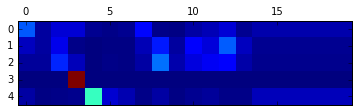

beam search using time(ms): 1543.81108284
word_ids [25394, 84, 2743, 20, 807, 752, 805, 31304, 3123, 84, 2102, 1804, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
0 [20, 807, 752, 2] 高/晓/松/<EOS> 0.038028326542 -3.26942 -3.26942 [-1.9974738, -0.012971662, -0.067989528, -1.1909888]


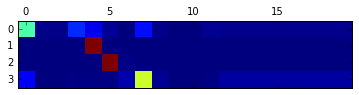

年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
1 [20, 807, 2] 高/晓/<EOS> 0.00171603690784 -6.36774 -6.36774 [-1.9974738, -0.012971662, -4.3572922]


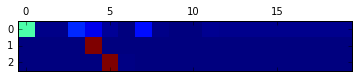

年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
2 [1804, 20, 807, 752, 2] 少年/高/晓/松/<EOS> 0.000743237116686 -7.2045 -7.2045 [-3.2880373, -3.3714812, -0.023195246, -0.17428678, -0.34749523]


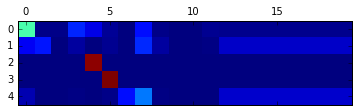

年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
3 [1804, 2] 少年/<EOS> 0.000734286771703 -7.21661 -7.21661 [-3.2880373, -3.9285738]


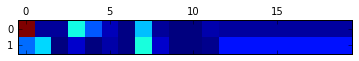

年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
4 [20, 807, 752, 20, 807, 752, 2] 高/晓/松/高/晓/松/<EOS> 0.000490546097624 -7.61999 -7.61999 [-1.9974738, -0.012971662, -0.067989528, -5.0889616, -0.037221007, -0.095668413, -0.31970528]


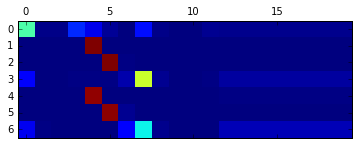

年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
5 [20, 807, 752, 1804, 2] 高/晓/松/少年/<EOS> 0.000340395430906 -7.9854 -7.9854 [-1.9974738, -0.012971662, -0.067989528, -5.2566719, -0.65029567]


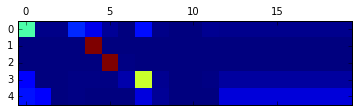

年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
6 [84, 2102, 2] 不/再/<EOS> 0.000124815230381 -8.98868 -8.98868 [-3.3536606, -1.1445863, -4.4904289]


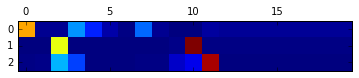

年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
7 [25394, 2] 年少/<EOS> 0.000102434897085 -9.18628 -9.18628 [-6.2580719, -2.928211]


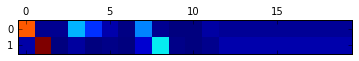

年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
8 [1804, 20, 807, 2] 少年/高/晓/<EOS> 8.96695056042e-05 -9.31938 -9.31938 [-3.2880373, -3.3714812, -0.023195246, -2.6366663]


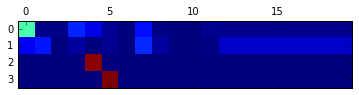

年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
9 [1804, 1804, 2] 少年/少年/<EOS> 6.79750560181e-05 -9.59637 -9.59637 [-3.2880373, -4.6793795, -1.628953]


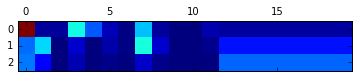

beam search using time(ms): 1503.95083427
word_ids [6423, 5, 5327, 1606, 60, 1274, 5, 805, 1606, 60, 9410, 6262, 805, 1606, 60, 9410, 1274, 0, 0, 0] len: 20
【/图/】/海贼/王/污/图/,/海贼/王/白马/觉醒/,/海贼/王/白马/污
【/图/】/海贼/王/污/图/,/海贼/王/白马/觉醒/,/海贼/王/白马/污
0 [1606, 60, 2] 海贼/王/<EOS> 0.0239535574038 -3.73164 -3.73164 [-0.19115797, -0.0042837765, -3.5361967]


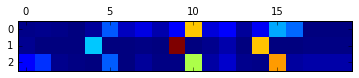

【/图/】/海贼/王/污/图/,/海贼/王/白马/觉醒/,/海贼/王/白马/污
1 [1606, 60, 9410, 2] 海贼/王/白马/<EOS> 0.0168029837065 -4.0862 -4.0862 [-0.19115797, -0.0042837765, -2.1294918, -1.761265]


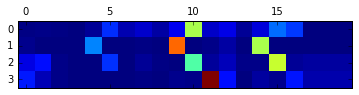

【/图/】/海贼/王/污/图/,/海贼/王/白马/觉醒/,/海贼/王/白马/污
2 [1606, 60, 1274, 5, 2] 海贼/王/污/图/<EOS> 0.00589830921783 -5.13309 -5.13309 [-0.19115797, -0.0042837765, -3.4221153, -1.2890168, -0.22651568]


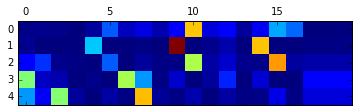

【/图/】/海贼/王/污/图/,/海贼/王/白马/觉醒/,/海贼/王/白马/污
3 [1606, 60, 1274, 2] 海贼/王/污/<EOS> 0.00328004627964 -5.7199 -5.7199 [-0.19115797, -0.0042837765, -3.4221153, -2.1023407]


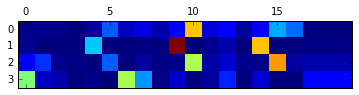

【/图/】/海贼/王/污/图/,/海贼/王/白马/觉醒/,/海贼/王/白马/污
4 [1606, 60, 5, 2] 海贼/王/图/<EOS> 0.00209713448044 -6.16718 -6.16718 [-0.19115797, -0.0042837765, -5.1766138, -0.79512805]


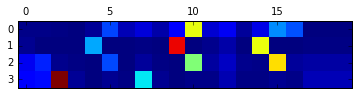

【/图/】/海贼/王/污/图/,/海贼/王/白马/觉醒/,/海贼/王/白马/污
5 [1606, 60, 1274, 1274, 2] 海贼/王/污/污/<EOS> 0.00136911630144 -6.59359 -6.59359 [-0.19115797, -0.0042837765, -3.4221153, -1.7886621, -1.1873709]


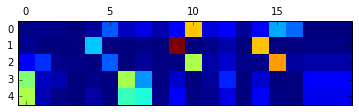

【/图/】/海贼/王/污/图/,/海贼/王/白马/觉醒/,/海贼/王/白马/污
6 [1274, 5, 2] 污/图/<EOS> 0.00122877399644 -6.70174 -6.70174 [-4.5522313, -1.322293, -0.827214]


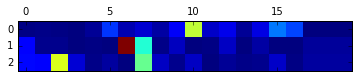

【/图/】/海贼/王/污/图/,/海贼/王/白马/觉醒/,/海贼/王/白马/污
7 [1606, 60, 9410, 5, 2] 海贼/王/白马/图/<EOS> 0.00121944591411 -6.70936 -6.70936 [-0.19115797, -0.0042837765, -2.1294918, -4.2459145, -0.13851069]


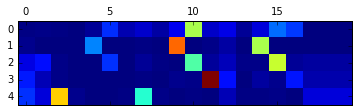

【/图/】/海贼/王/污/图/,/海贼/王/白马/觉醒/,/海贼/王/白马/污
8 [1606, 60, 1274, 1274, 5, 2] 海贼/王/污/污/图/<EOS> 0.000951745921362 -6.95721 -6.95721 [-0.19115797, -0.0042837765, -3.4221153, -1.7886621, -1.4478422, -0.10315142]


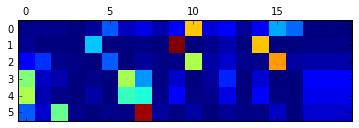

【/图/】/海贼/王/污/图/,/海贼/王/白马/觉醒/,/海贼/王/白马/污
9 [9410, 2] 白马/<EOS> 0.000529277712361 -7.544 -7.544 [-5.2029958, -2.3410015]


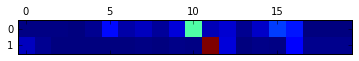

beam search using time(ms): 1619.58813667
word_ids [962, 741, 238, 3161, 246, 2500, 48, 216, 319, 716, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
美国/摄影/师/拍摄/唯美/孕妇/水/下/写真/艺术/照
美国/摄影/师/拍摄/唯美/孕妇/水/下/写真/艺术/照
0 [48, 216, 716, 17, 2] 水/下/艺术/照/<EOS> 0.0495340363111 -3.0051 -3.0051 [-1.2131789, -0.1439136, -1.384083, -0.14429197, -0.11962765]


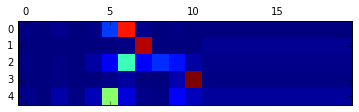

美国/摄影/师/拍摄/唯美/孕妇/水/下/写真/艺术/照
1 [48, 216, 319, 2] 水/下/写真/<EOS> 0.02486818052 -3.69417 -3.69417 [-1.2131789, -0.1439136, -1.6081927, -0.72888088]


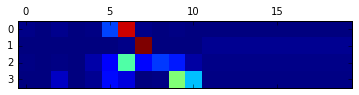

美国/摄影/师/拍摄/唯美/孕妇/水/下/写真/艺术/照
2 [48, 216, 741, 2] 水/下/摄影/<EOS> 0.0196047391667 -3.93198 -3.93198 [-1.2131789, -0.1439136, -1.7968104, -0.77808106]


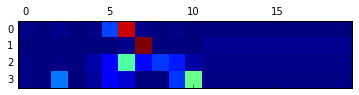

美国/摄影/师/拍摄/唯美/孕妇/水/下/写真/艺术/照
3 [741, 716, 17, 2] 摄影/艺术/照/<EOS> 0.0122599287172 -4.40142 -4.40142 [-2.565594, -1.0154327, -0.39498505, -0.42540756]


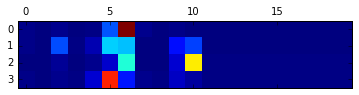

美国/摄影/师/拍摄/唯美/孕妇/水/下/写真/艺术/照
4 [716, 741, 2] 艺术/摄影/<EOS> 0.0114781347181 -4.46731 -4.46731 [-2.3310082, -0.9856478, -1.1506554]


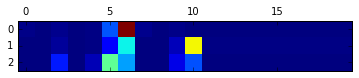

美国/摄影/师/拍摄/唯美/孕妇/水/下/写真/艺术/照
5 [246, 741, 716, 17, 2] 唯美/摄影/艺术/照/<EOS> 0.0100123188774 -4.60394 -4.60394 [-2.2420762, -0.90067422, -1.1761556, -0.13887285, -0.14616047]


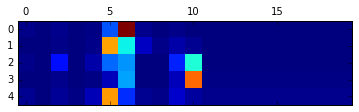

美国/摄影/师/拍摄/唯美/孕妇/水/下/写真/艺术/照
6 [48, 216, 741, 716, 17, 2] 水/下/摄影/艺术/照/<EOS> 0.00862546007153 -4.75304 -4.75304 [-1.2131789, -0.1439136, -1.7968104, -1.3126346, -0.22032127, -0.06617818]


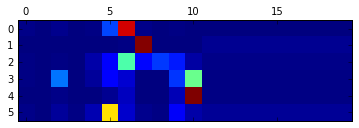

美国/摄影/师/拍摄/唯美/孕妇/水/下/写真/艺术/照
7 [48, 216, 2] 水/下/<EOS> 0.00813760580229 -4.81126 -4.81126 [-1.2131789, -0.1439136, -3.4541667]


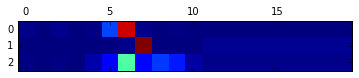

美国/摄影/师/拍摄/唯美/孕妇/水/下/写真/艺术/照
8 [48, 216, 319, 716, 17, 2] 水/下/写真/艺术/照/<EOS> 0.00806698577707 -4.81998 -4.81998 [-1.2131789, -0.1439136, -1.6081927, -1.6243086, -0.16065514, -0.069726452]


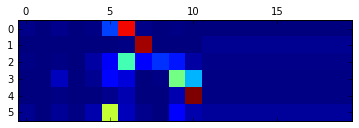

美国/摄影/师/拍摄/唯美/孕妇/水/下/写真/艺术/照
9 [716, 17, 2] 艺术/照/<EOS> 0.0066593776788 -5.01173 -5.01173 [-2.3310082, -0.94943106, -1.73129]


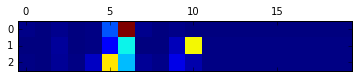

beam search using time(ms): 1898.624897
word_ids [7614, 63, 30, 4194, 4930, 6099, 784, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
精选/高清/壁纸/：/孙俪/邓超/婚纱/照
精选/高清/壁纸/：/孙俪/邓超/婚纱/照
0 [6099, 784, 17, 2] 邓超/婚纱/照/<EOS> 0.115889018823 -2.15512 -2.15512 [-0.49745893, -1.0169417, -0.22712702, -0.41359472]


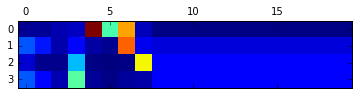

精选/高清/壁纸/：/孙俪/邓超/婚纱/照
1 [4930, 784, 17, 2] 孙俪/婚纱/照/<EOS> 0.0515467934047 -2.96527 -2.96527 [-1.219913, -0.98668981, -0.27887601, -0.4797864]


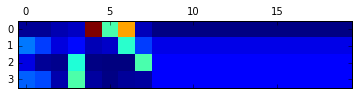

精选/高清/壁纸/：/孙俪/邓超/婚纱/照
2 [6099, 2] 邓超/<EOS> 0.0259427993182 -3.65186 -3.65186 [-0.49745893, -3.1544023]


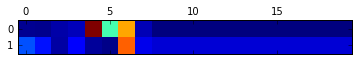

精选/高清/壁纸/：/孙俪/邓超/婚纱/照
3 [6099, 784, 2] 邓超/婚纱/<EOS> 0.012096019527 -4.41488 -4.41488 [-0.49745893, -1.0169417, -2.9004784]


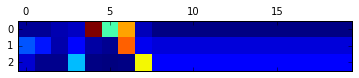

精选/高清/壁纸/：/孙俪/邓超/婚纱/照
4 [6099, 63, 30, 2] 邓超/高清/壁纸/<EOS> 0.00966656329063 -4.63908 -4.63908 [-0.49745893, -2.5161576, -1.4589169, -0.16654916]


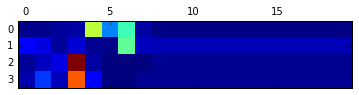

精选/高清/壁纸/：/孙俪/邓超/婚纱/照
5 [6099, 6099, 784, 17, 2] 邓超/邓超/婚纱/照/<EOS> 0.00829494082284 -4.79211 -4.79211 [-0.49745893, -2.6698585, -1.2600528, -0.19104837, -0.17369126]


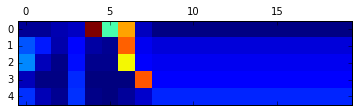

精选/高清/壁纸/：/孙俪/邓超/婚纱/照
6 [6099, 6099, 2] 邓超/邓超/<EOS> 0.00789577992169 -4.84143 -4.84143 [-0.49745893, -2.6698585, -1.6741096]


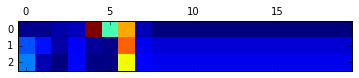

精选/高清/壁纸/：/孙俪/邓超/婚纱/照
7 [6099, 30, 2] 邓超/壁纸/<EOS> 0.00765378655531 -4.87255 -4.87255 [-0.49745893, -3.6170144, -0.75808161]


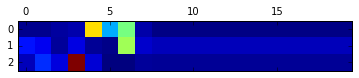

精选/高清/壁纸/：/孙俪/邓超/婚纱/照
8 [4930, 2] 孙俪/<EOS> 0.00736958624416 -4.91039 -4.91039 [-1.219913, -3.6904805]


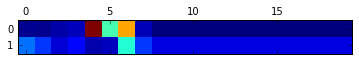

精选/高清/壁纸/：/孙俪/邓超/婚纱/照
9 [6099, 63, 2] 邓超/高清/<EOS> 0.00616712255123 -5.08852 -5.08852 [-0.49745893, -2.5161576, -2.0749066]


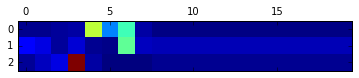

beam search using time(ms): 1543.27702522
word_ids [35391, 1579, 8, 16898, 1703, 13476, 3393, 10617, 4103, 982, 8039, 1133, 1012, 1086, 1580, 1064, 6394, 0, 0, 0] len: 20
英孚/英语/ /出国/难/开口/？/每天/充电/5/分钟/，/真实/旅游/场景/视频/课程
英孚/英语/ /出国/难/开口/？/每天/充电/5/分钟/，/真实/旅游/场景/视频/课程
0 [1579, 2] 英语/<EOS> 0.00023971277862 -8.33607 -8.33607 [-3.0940297, -5.2420392]


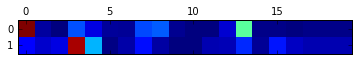

英孚/英语/ /出国/难/开口/？/每天/充电/5/分钟/，/真实/旅游/场景/视频/课程
1 [16898, 2] 出国/<EOS> 0.000214790071462 -8.44585 -8.44585 [-4.5077934, -3.9380562]


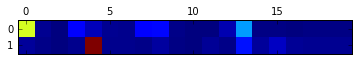

英孚/英语/ /出国/难/开口/？/每天/充电/5/分钟/，/真实/旅游/场景/视频/课程
2 [35391, 2] 英孚/<EOS> 0.000185339933759 -8.59332 -8.59332 [-6.1775417, -2.4157777]


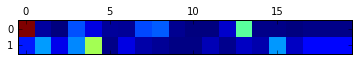

英孚/英语/ /出国/难/开口/？/每天/充电/5/分钟/，/真实/旅游/场景/视频/课程
3 [1579, 1580, 2] 英语/场景/<EOS> 0.000185265181923 -8.59372 -8.59372 [-3.0940297, -4.7363229, -0.76336914]


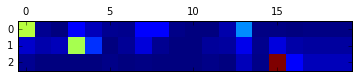

英孚/英语/ /出国/难/开口/？/每天/充电/5/分钟/，/真实/旅游/场景/视频/课程
4 [16898, 1703, 2] 出国/难/<EOS> 0.000142698387123 -8.85478 -8.85478 [-4.5077934, -3.2494671, -1.097517]


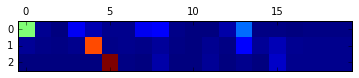

英孚/英语/ /出国/难/开口/？/每天/充电/5/分钟/，/真实/旅游/场景/视频/课程
5 [1579, 6394, 2] 英语/课程/<EOS> 0.000132669371726 -8.92765 -8.92765 [-3.0940297, -4.7532916, -1.0803285]


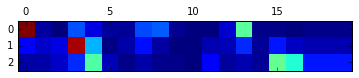

英孚/英语/ /出国/难/开口/？/每天/充电/5/分钟/，/真实/旅游/场景/视频/课程
6 [1579, 1579, 2] 英语/英语/<EOS> 0.000118205597461 -9.04309 -9.04309 [-3.0940297, -3.4060655, -2.5429897]


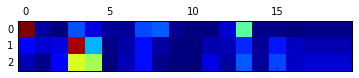

英孚/英语/ /出国/难/开口/？/每天/充电/5/分钟/，/真实/旅游/场景/视频/课程
7 [4103, 2] 充电/<EOS> 0.000113352335728 -9.08501 -9.08501 [-6.774189, -2.3108206]


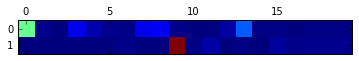

英孚/英语/ /出国/难/开口/？/每天/充电/5/分钟/，/真实/旅游/场景/视频/课程
8 [982, 8039, 2] 5/分钟/<EOS> 9.80327108713e-05 -9.23021 -9.23021 [-6.6383343, -0.40965375, -2.1822209]


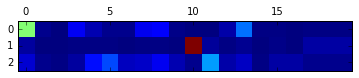

英孚/英语/ /出国/难/开口/？/每天/充电/5/分钟/，/真实/旅游/场景/视频/课程
9 [1579, 16898, 2] 英语/出国/<EOS> 8.81305027362e-05 -9.33669 -9.33669 [-3.0940297, -4.6451364, -1.597526]


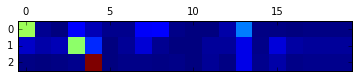

beam search using time(ms): 1573.0919838
word_ids [42999, 164, 926, 649, 9, 869, 1474, 363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
酷似/刘/亦/菲/的/朴/姬/兰
酷似/刘/亦/菲/的/朴/姬/兰
0 [869, 1474, 363, 2] 朴/姬/兰/<EOS> 0.0535630988022 -2.92689 -2.92689 [-1.7833743, -0.062784657, -0.48825479, -0.59248114]


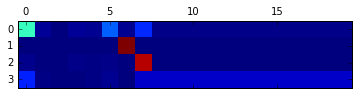

酷似/刘/亦/菲/的/朴/姬/兰
1 [164, 926, 649, 2] 刘/亦/菲/<EOS> 0.028028940119 -3.57452 -3.57452 [-0.83828402, -0.0043840725, -0.0028420791, -2.7290075]


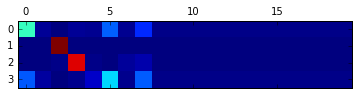

酷似/刘/亦/菲/的/朴/姬/兰
2 [869, 1474, 2] 朴/姬/<EOS> 0.00948850857966 -4.65767 -4.65767 [-1.7833743, -0.062784657, -2.8115151]


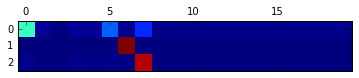

酷似/刘/亦/菲/的/朴/姬/兰
3 [164, 926, 649, 869, 1474, 2] 刘/亦/菲/朴/姬/<EOS> 0.00370250263647 -5.59875 -5.59875 [-0.83828402, -0.0043840725, -0.0028420791, -3.3004167, -0.089011654, -1.3638079]


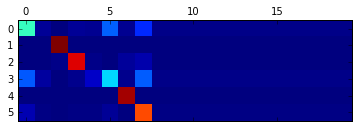

酷似/刘/亦/菲/的/朴/姬/兰
4 [164, 926, 649, 164, 926, 649, 2] 刘/亦/菲/刘/亦/菲/<EOS> 0.00137773081974 -6.58732 -6.58732 [-0.83828402, -0.0043840725, -0.0028420791, -4.6451387, -0.0099844309, -0.0037226442, -1.0829617]


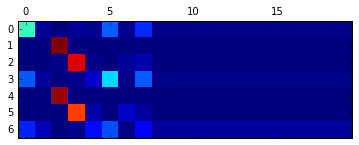

酷似/刘/亦/菲/的/朴/姬/兰
5 [869, 1474, 363, 164, 926, 649, 2] 朴/姬/兰/刘/亦/菲/<EOS> 0.00113647948557 -6.77982 -6.77982 [-1.7833743, -0.062784657, -0.48825479, -4.0615411, -0.0095973527, -0.010322751, -0.36394504]


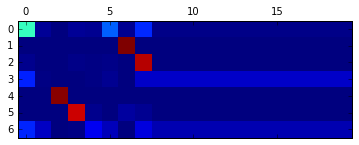

酷似/刘/亦/菲/的/朴/姬/兰
6 [164, 926, 649, 869, 1474, 363, 2] 刘/亦/菲/朴/姬/兰/<EOS> 0.00110033095144 -6.81214 -6.81214 [-0.83828402, -0.0043840725, -0.0028420791, -3.3004167, -0.089011654, -2.1054442, -0.47176185]


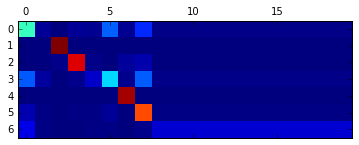

酷似/刘/亦/菲/的/朴/姬/兰
7 [1474, 363, 2] 姬/兰/<EOS> 0.00104618147642 -6.86261 -6.86261 [-5.9007649, -0.17869344, -0.78315008]


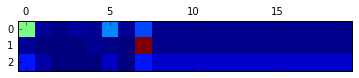

酷似/刘/亦/菲/的/朴/姬/兰
8 [869, 1474, 164, 926, 649, 2] 朴/姬/刘/亦/菲/<EOS> 0.00103398175303 -6.87434 -6.87434 [-1.7833743, -0.062784657, -4.4844484, -0.023370411, -0.0045223343, -0.51583821]


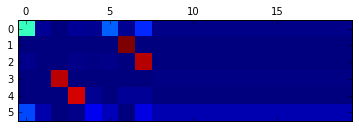

酷似/刘/亦/菲/的/朴/姬/兰
9 [869, 1474, 1474, 2] 朴/姬/姬/<EOS> 0.000383783935421 -7.86543 -7.86543 [-1.7833743, -0.062784657, -5.3249969, -0.69427496]


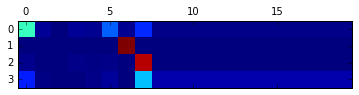

beam search using time(ms): 1605.17191887
word_ids [42999, 869, 1474, 363, 9, 164, 926, 649, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
酷似/朴/姬/兰/的/刘/亦/菲
酷似/朴/姬/兰/的/刘/亦/菲
0 [164, 926, 649, 2] 刘/亦/菲/<EOS> 0.0444470906037 -3.11346 -3.11346 [-0.87219727, -0.0066159968, -0.003116277, -2.2315264]


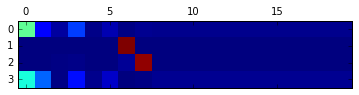

酷似/朴/姬/兰/的/刘/亦/菲
1 [869, 1474, 363, 2] 朴/姬/兰/<EOS> 0.0423516081352 -3.16175 -3.16175 [-2.1100721, -0.12875201, -0.36370304, -0.55922174]


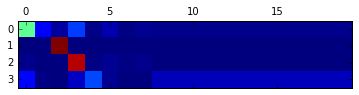

酷似/朴/姬/兰/的/刘/亦/菲
2 [869, 1474, 2] 朴/姬/<EOS> 0.00518600459366 -5.26179 -5.26179 [-2.1100721, -0.12875201, -3.0229676]


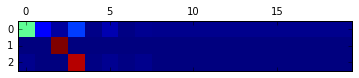

酷似/朴/姬/兰/的/刘/亦/菲
3 [164, 926, 649, 869, 1474, 2] 刘/亦/菲/朴/姬/<EOS> 0.00207802622664 -6.17634 -6.17634 [-0.87219727, -0.0066159968, -0.003116277, -3.9154634, -0.29994857, -1.0789951]


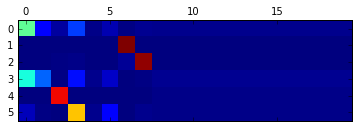

酷似/朴/姬/兰/的/刘/亦/菲
4 [164, 926, 649, 164, 926, 649, 2] 刘/亦/菲/刘/亦/菲/<EOS> 0.00204642408476 -6.19166 -6.19166 [-0.87219727, -0.0066159968, -0.003116277, -4.3764906, -0.016692374, -0.0018467529, -0.9147023]


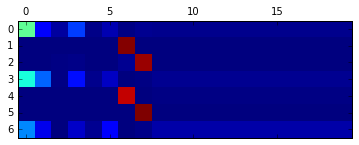

酷似/朴/姬/兰/的/刘/亦/菲
5 [869, 1474, 363, 164, 926, 649, 2] 朴/姬/兰/刘/亦/菲/<EOS> 0.00157321017357 -6.45464 -6.45464 [-2.1100721, -0.12875201, -0.36370304, -3.4230542, -0.010592311, -0.010010396, -0.40845305]


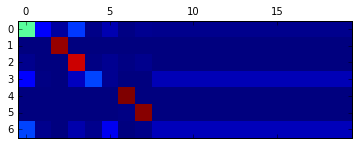

酷似/朴/姬/兰/的/刘/亦/菲
6 [1474, 363, 2] 姬/兰/<EOS> 0.000421991873256 -7.77052 -7.77052 [-6.5108557, -0.43780333, -0.82186556]


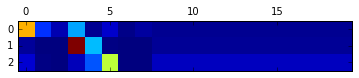

酷似/朴/姬/兰/的/刘/亦/菲
7 [869, 1474, 164, 926, 649, 2] 朴/姬/刘/亦/菲/<EOS> 0.000324193450547 -8.03417 -8.03417 [-2.1100721, -0.12875201, -5.2336621, -0.024313141, -0.0041192453, -0.53325117]


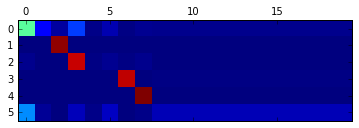

酷似/朴/姬/兰/的/刘/亦/菲
8 [363, 2] 兰/<EOS> 0.000143552981589 -8.84881 -8.84881 [-6.2535801, -2.5952263]


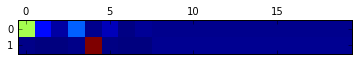

酷似/朴/姬/兰/的/刘/亦/菲
9 [164, 926, 649, 869, 1474, 363, 2] 刘/亦/菲/朴/姬/兰/<EOS> 0.000142889309808 -8.85344 -8.85344 [-0.87219727, -0.0066159968, -0.003116277, -3.9154634, -0.29994857, -3.302916, -0.45318329]


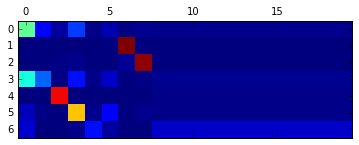

beam search using time(ms): 1575.5610466
word_ids [16898, 84, 124, 639, 1579, 3393, 10617, 982, 8039, 1133, 11347, 13476, 639, 0, 0, 0, 0, 0, 0, 0] len: 20
出国/不/会/说/英语/？/每天/5/分钟/，/自信/开口/说
出国/不/会/说/英语/？/每天/5/分钟/，/自信/开口/说
0 [1579, 1579, 2] 英语/英语/<EOS> 0.00245578850872 -6.00931 -6.00931 [-2.1895812, -2.3757348, -1.4439913]


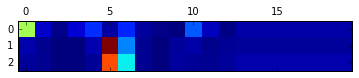

出国/不/会/说/英语/？/每天/5/分钟/，/自信/开口/说
1 [1579, 2] 英语/<EOS> 0.00175835236084 -6.34338 -6.34338 [-2.1895812, -4.1537967]


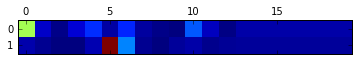

出国/不/会/说/英语/？/每天/5/分钟/，/自信/开口/说
2 [84, 124, 639, 1579, 2] 不/会/说/英语/<EOS> 0.00141118513674 -6.56333 -6.56333 [-3.9266388, -0.80447221, -0.12476525, -1.1475925, -0.5598563]


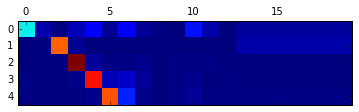

出国/不/会/说/英语/？/每天/5/分钟/，/自信/开口/说
3 [639, 1579, 2] 说/英语/<EOS> 0.000816662758626 -7.11028 -7.11028 [-4.2939062, -1.2525984, -1.5637798]


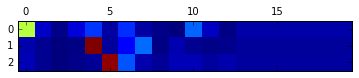

出国/不/会/说/英语/？/每天/5/分钟/，/自信/开口/说
4 [84, 124, 639, 2] 不/会/说/<EOS> 0.00067871221396 -7.29531 -7.29531 [-3.9266388, -0.80447221, -0.12476525, -2.4394369]


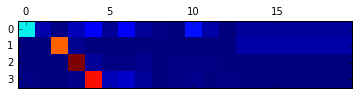

出国/不/会/说/英语/？/每天/5/分钟/，/自信/开口/说
5 [16898, 84, 124, 639, 2] 出国/不/会/说/<EOS> 0.000379280523576 -7.87723 -7.87723 [-4.1521387, -1.6425778, -0.57255393, -0.32359993, -1.1863639]


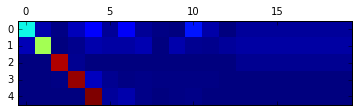

出国/不/会/说/英语/？/每天/5/分钟/，/自信/开口/说
6 [16898, 1579, 2] 出国/英语/<EOS> 0.000357776627699 -7.9356 -7.9356 [-4.1521387, -3.0197139, -0.76374924]


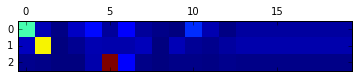

出国/不/会/说/英语/？/每天/5/分钟/，/自信/开口/说
7 [16898, 2] 出国/<EOS> 0.000353540290388 -7.94751 -7.94751 [-4.1521387, -3.7953744]


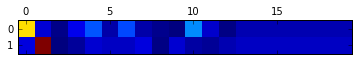

出国/不/会/说/英语/？/每天/5/分钟/，/自信/开口/说
8 [11347, 2] 自信/<EOS> 0.000136984176117 -8.89565 -8.89565 [-5.9934769, -2.9021688]


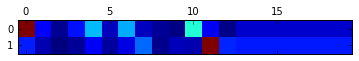

出国/不/会/说/英语/？/每天/5/分钟/，/自信/开口/说
9 [16898, 84, 124, 2] 出国/不/会/<EOS> 0.000130190941077 -8.94651 -8.94651 [-4.1521387, -1.6425778, -0.57255393, -2.5792379]


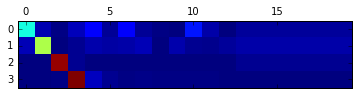

beam search using time(ms): 1746.74510956
word_ids [10113, 15, 6199, 3473, 313, 3110, 5594, 5680, 1133, 1551, 427, 215, 1660, 63037, 316, 0, 0, 0, 0, 0] len: 20
河源/人/凭/身份/证/可以/申请/贷款/，/10/万/月/息/257/元
河源/人/凭/身份/证/可以/申请/贷款/，/10/万/月/息/257/元
0 [3473, 313, 2] 身份/证/<EOS> 0.00860051421766 -4.75593 -4.75593 [-1.3687216, -0.0012159105, -3.3859959]


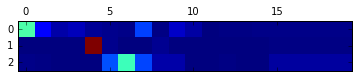

河源/人/凭/身份/证/可以/申请/贷款/，/10/万/月/息/257/元
1 [5680, 3473, 313, 2] 贷款/身份/证/<EOS> 0.00603112209122 -5.11082 -5.11082 [-2.391438, -1.763927, -0.0048245448, -0.95063239]


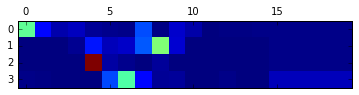

河源/人/凭/身份/证/可以/申请/贷款/，/10/万/月/息/257/元
2 [5680, 2] 贷款/<EOS> 0.00347117416129 -5.66326 -5.66326 [-2.391438, -3.2718244]


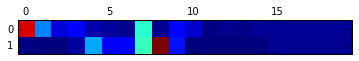

河源/人/凭/身份/证/可以/申请/贷款/，/10/万/月/息/257/元
3 [5680, 5680, 2] 贷款/贷款/<EOS> 0.00235021962415 -6.05325 -6.05325 [-2.391438, -2.1016116, -1.5601969]


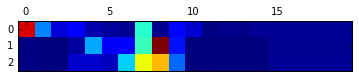

河源/人/凭/身份/证/可以/申请/贷款/，/10/万/月/息/257/元
4 [3473, 313, 5680, 2] 身份/证/贷款/<EOS> 0.00187176705524 -6.28087 -6.28087 [-1.3687216, -0.0012159105, -3.7445507, -1.1663845]


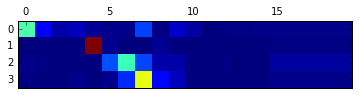

河源/人/凭/身份/证/可以/申请/贷款/，/10/万/月/息/257/元
5 [3473, 313, 3473, 313, 2] 身份/证/身份/证/<EOS> 0.00115681695068 -6.76208 -6.76208 [-1.3687216, -0.0012159105, -3.2895861, -0.033971112, -2.0685883]


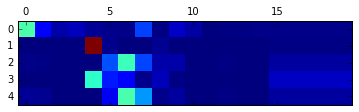

河源/人/凭/身份/证/可以/申请/贷款/，/10/万/月/息/257/元
6 [3473, 313, 5594, 2] 身份/证/申请/<EOS> 0.00058571540451 -7.44268 -7.44268 [-1.3687216, -0.0012159105, -4.1095581, -1.9631811]


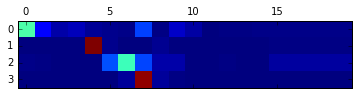

河源/人/凭/身份/证/可以/申请/贷款/，/10/万/月/息/257/元
7 [10113, 3473, 313, 2] 河源/身份/证/<EOS> 0.000584173796208 -7.44531 -7.44531 [-5.1704211, -1.5530469, -0.0011045791, -0.72073984]


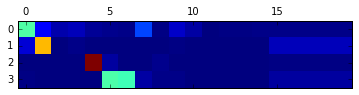

河源/人/凭/身份/证/可以/申请/贷款/，/10/万/月/息/257/元
8 [10113, 15, 3473, 313, 2] 河源/人/身份/证/<EOS> 0.000523843806368 -7.55432 -7.55432 [-5.1704211, -1.0193994, -0.70285386, -0.0030543602, -0.65858883]


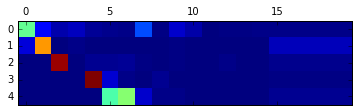

河源/人/凭/身份/证/可以/申请/贷款/，/10/万/月/息/257/元
9 [5680, 5594, 5680, 2] 贷款/申请/贷款/<EOS> 0.000477276673246 -7.64741 -7.64741 [-2.391438, -3.1117368, -1.1860325, -0.95820695]


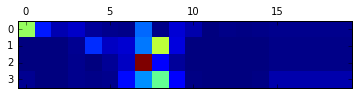

beam search using time(ms): 1561.24401093
word_ids [51, 1582, 235, 14508, 6394, 2089, 5443, 698, 1939, 19373, 1678, 6456, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
学/完/了/这些/课程/才/知道/什么/叫/全能/产品/经理
学/完/了/这些/课程/才/知道/什么/叫/全能/产品/经理
0 [6394, 2] 课程/<EOS> 0.00108778969446 -6.82361 -6.82361 [-4.6512699, -2.1723375]


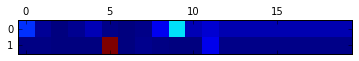

学/完/了/这些/课程/才/知道/什么/叫/全能/产品/经理
1 [1678, 6456, 2] 产品/经理/<EOS> 0.000334200675387 -8.00377 -8.00377 [-4.8404942, -2.1020458, -1.0612291]


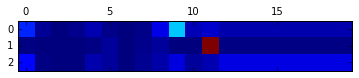

学/完/了/这些/课程/才/知道/什么/叫/全能/产品/经理
2 [19373, 2] 全能/<EOS> 0.000155194395588 -8.77083 -8.77083 [-5.5949411, -3.1758909]


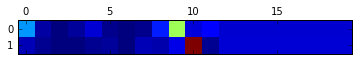

学/完/了/这些/课程/才/知道/什么/叫/全能/产品/经理
3 [1678, 2] 产品/<EOS> 0.000119364351685 -9.03333 -9.03333 [-4.8404942, -4.1928358]


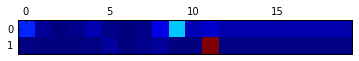

学/完/了/这些/课程/才/知道/什么/叫/全能/产品/经理
4 [51, 1582, 2] 学/完/<EOS> 5.65136817712e-05 -9.78103 -9.78103 [-5.8777094, -2.3194447, -1.5838734]


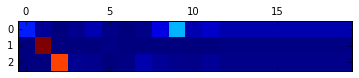

学/完/了/这些/课程/才/知道/什么/叫/全能/产品/经理
5 [6394, 51, 2] 课程/学/<EOS> 4.14560957027e-05 -10.0909 -10.0909 [-4.6512699, -4.5065069, -0.93309927]


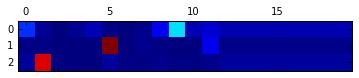

学/完/了/这些/课程/才/知道/什么/叫/全能/产品/经理
6 [19373, 1678, 2] 全能/产品/<EOS> 3.39224563274e-05 -10.2914 -10.2914 [-5.5949411, -3.6592236, -1.0372684]


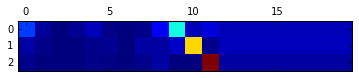

学/完/了/这些/课程/才/知道/什么/叫/全能/产品/经理
7 [6394, 6456, 2] 课程/经理/<EOS> 1.81518420847e-05 -10.9167 -10.9167 [-4.6512699, -5.4582758, -0.8071931]


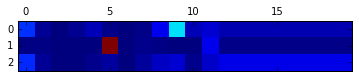

学/完/了/这些/课程/才/知道/什么/叫/全能/产品/经理
8 [6394, 6394, 2] 课程/课程/<EOS> 1.38316918474e-05 -11.1885 -11.1885 [-4.6512699, -5.5456314, -0.99164641]


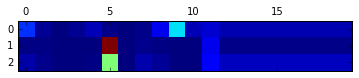

学/完/了/这些/课程/才/知道/什么/叫/全能/产品/经理
9 [51, 2] 学/<EOS> 1.30008859916e-05 -11.2505 -11.2505 [-5.8777094, -5.3727837]


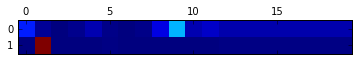

beam search using time(ms): 1553.70593071
word_ids [700, 1161, 14499, 235, 1133, 1428, 1428, 214, 194, 68785, 26997, 210, 4115, 9740, 3393, 0, 0, 0, 0, 0] len: 20
要/考/雅思/了/，/测/测/你/在/考官/眼里/是/啥/水平/？
要/考/雅思/了/，/测/测/你/在/考官/眼里/是/啥/水平/？
0 [14499, 2] 雅思/<EOS> 0.00157291238622 -6.45483 -6.45483 [-3.2119117, -3.2429147]


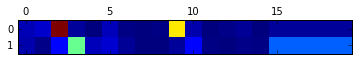

要/考/雅思/了/，/测/测/你/在/考官/眼里/是/啥/水平/？
1 [1161, 14499, 2] 考/雅思/<EOS> 0.00119225671606 -6.73191 -6.73191 [-3.5391059, -1.7268932, -1.4659084]


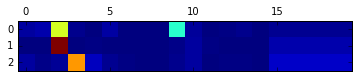

要/考/雅思/了/，/测/测/你/在/考官/眼里/是/啥/水平/？
2 [1428, 1428, 2] 测/测/<EOS> 0.000622909250879 -7.38111 -7.38111 [-4.1367078, -1.1336265, -2.1107755]


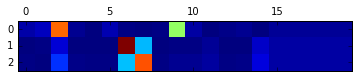

要/考/雅思/了/，/测/测/你/在/考官/眼里/是/啥/水平/？
3 [1161, 2] 考/<EOS> 0.000376853470839 -7.88365 -7.88365 [-3.5391059, -4.3445482]


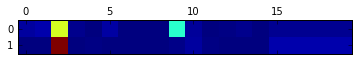

要/考/雅思/了/，/测/测/你/在/考官/眼里/是/啥/水平/？
4 [1161, 1161, 2] 考/考/<EOS> 0.000356779661173 -7.93839 -7.93839 [-3.5391059, -2.2148321, -2.1844544]


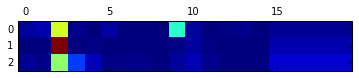

要/考/雅思/了/，/测/测/你/在/考官/眼里/是/啥/水平/？
5 [1428, 2] 测/<EOS> 5.68891208342e-05 -9.77441 -9.77441 [-4.1367078, -5.6376987]


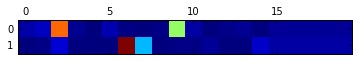

要/考/雅思/了/，/测/测/你/在/考官/眼里/是/啥/水平/？
6 [1428, 1428, 214, 2] 测/测/你/<EOS> 4.44190131298e-05 -10.0218 -10.0218 [-4.1367078, -1.1336265, -3.1559873, -1.5955218]


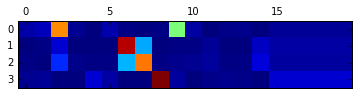

要/考/雅思/了/，/测/测/你/在/考官/眼里/是/啥/水平/？
7 [1428, 1161, 2] 测/考/<EOS> 4.15200345111e-05 -10.0893 -10.0893 [-4.1367078, -3.4915404, -2.4610858]


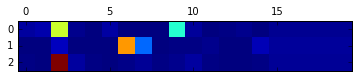

要/考/雅思/了/，/测/测/你/在/考官/眼里/是/啥/水平/？
8 [700, 1161, 14499, 2] 要/考/雅思/<EOS> 2.63223391309e-05 -10.5451 -10.5451 [-8.0900564, -0.10404585, -1.2607337, -1.0902563]


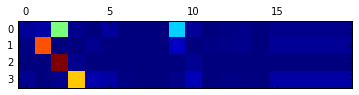

要/考/雅思/了/，/测/测/你/在/考官/眼里/是/啥/水平/？
9 [1428, 1428, 235, 2] 测/测/了/<EOS> 2.00624262174e-05 -10.8167 -10.8167 [-4.1367078, -1.1336265, -4.4835267, -1.0628011]


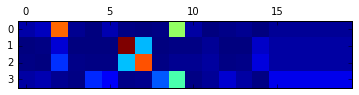

beam search using time(ms): 1487.46609688
word_ids [67, 41, 8330, 4194, 20, 443, 2383, 427, 18920, 1133, 687, 2182, 2949, 8039, 584, 2622, 1133, 1428, 1428, 214] len: 20
最/新/消息/：/高/达/20/万/借款/，/快/至/30/分钟/到/账/，/测/测/你
最/新/消息/：/高/达/20/万/借款/，/快/至/30/分钟/到/账/，/测/测/你
0 [20, 443, 2] 高/达/<EOS> 0.00720171965819 -4.93344 -4.93344 [-2.4412749, -0.0052604354, -2.4868999]


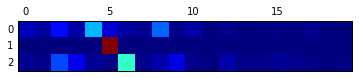

最/新/消息/：/高/达/20/万/借款/，/快/至/30/分钟/到/账/，/测/测/你
1 [67, 41, 8330, 2] 最/新/消息/<EOS> 0.00203327646327 -6.19811 -6.19811 [-4.0893621, -0.069779932, -0.42692593, -1.6120385]


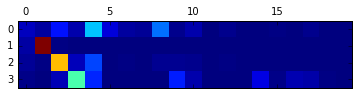

最/新/消息/：/高/达/20/万/借款/，/快/至/30/分钟/到/账/，/测/测/你
2 [20, 443, 67, 41, 8330, 2] 高/达/最/新/消息/<EOS> 0.000224996331516 -8.39943 -8.39943 [-2.4412749, -0.0052604354, -5.3680682, -0.074893974, -0.10048845, -0.40944013]


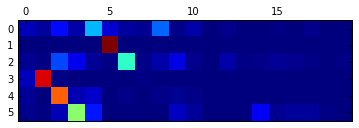

最/新/消息/：/高/达/20/万/借款/，/快/至/30/分钟/到/账/，/测/测/你
3 [18920, 2] 借款/<EOS> 0.000194425655679 -8.54546 -8.54546 [-6.5840168, -1.9614437]


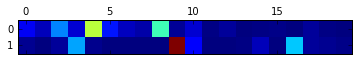

最/新/消息/：/高/达/20/万/借款/，/快/至/30/分钟/到/账/，/测/测/你
4 [20, 443, 2383, 427, 2] 高/达/20/万/<EOS> 0.000107022516241 -9.14247 -9.14247 [-2.4412749, -0.0052604354, -5.4217858, -0.093350217, -1.1807994]


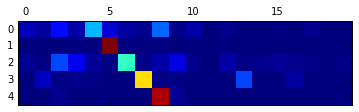

最/新/消息/：/高/达/20/万/借款/，/快/至/30/分钟/到/账/，/测/测/你
5 [687, 584, 2] 快/到/<EOS> 9.87463907977e-05 -9.22296 -9.22296 [-5.4373655, -0.29039595, -3.495194]


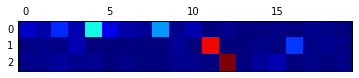

最/新/消息/：/高/达/20/万/借款/，/快/至/30/分钟/到/账/，/测/测/你
6 [2383, 427, 2] 20/万/<EOS> 5.92109205756e-05 -9.7344 -9.7344 [-6.1521521, -0.5522908, -3.0299618]


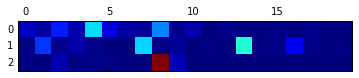

最/新/消息/：/高/达/20/万/借款/，/快/至/30/分钟/到/账/，/测/测/你
7 [41, 8330, 2] 新/消息/<EOS> 5.2050779515e-05 -9.86329 -9.86329 [-4.3025093, -3.6196887, -1.9410927]


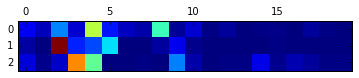

最/新/消息/：/高/达/20/万/借款/，/快/至/30/分钟/到/账/，/测/测/你
8 [67, 41, 20, 443, 2] 最/新/高/达/<EOS> 4.62167534126e-05 -9.98217 -9.98217 [-4.0893621, -0.069779932, -4.3286576, -0.012756769, -1.4816122]


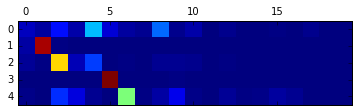

最/新/消息/：/高/达/20/万/借款/，/快/至/30/分钟/到/账/，/测/测/你
9 [20, 443, 20, 443, 2] 高/达/高/达/<EOS> 3.24073657019e-05 -10.3371 -10.3371 [-2.4412749, -0.0052604354, -6.7204833, -0.014268283, -1.1558378]


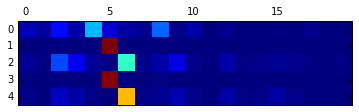

beam search using time(ms): 1530.58409691
word_ids [84, 1059, 9631, 19067, 1133, 12156, 427, 17465, 14211, 1133, 7627, 9, 42964, 1490, 1545, 84, 1545, 3393, 0, 0] len: 20
不/限/社保/用药/，/240/万/任性/报销/，/这样/的/防癌/险/买/不/买/？
不/限/社保/用药/，/240/万/任性/报销/，/这样/的/防癌/险/买/不/买/？
0 [9631, 2] 社保/<EOS> 0.00534976885666 -5.2307 -5.2307 [-2.9489317, -2.2817702]


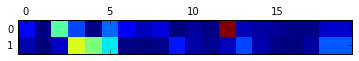

不/限/社保/用药/，/240/万/任性/报销/，/这样/的/防癌/险/买/不/买/？
1 [9631, 14211, 2] 社保/报销/<EOS> 0.00110692854903 -6.80617 -6.80617 [-2.9489317, -2.440743, -1.4164915]


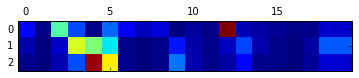

不/限/社保/用药/，/240/万/任性/报销/，/这样/的/防癌/险/买/不/买/？
2 [1545, 84, 1545, 2] 买/不/买/<EOS> 0.000485304298752 -7.63073 -7.63073 [-4.2319584, -0.60327303, -1.2732414, -1.5222615]


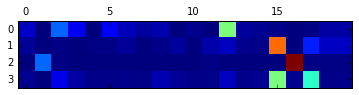

不/限/社保/用药/，/240/万/任性/报销/，/这样/的/防癌/险/买/不/买/？
3 [84, 1059, 2] 不/限/<EOS> 0.000358021353466 -7.93492 -7.93492 [-3.2089024, -1.114854, -3.6111617]


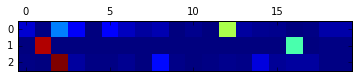

不/限/社保/用药/，/240/万/任性/报销/，/这样/的/防癌/险/买/不/买/？
4 [14211, 2] 报销/<EOS> 0.000347383660804 -7.96508 -7.96508 [-5.9170647, -2.0480161]


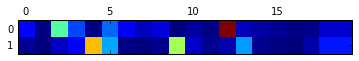

不/限/社保/用药/，/240/万/任性/报销/，/这样/的/防癌/险/买/不/买/？
5 [84, 1059, 9631, 2] 不/限/社保/<EOS> 0.000304209032346 -8.0978 -8.0978 [-3.2089024, -1.114854, -2.630053, -1.1439861]


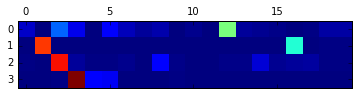

不/限/社保/用药/，/240/万/任性/报销/，/这样/的/防癌/险/买/不/买/？
6 [19067, 2] 用药/<EOS> 0.000103811523347 -9.17293 -9.17293 [-7.0111437, -2.1617901]


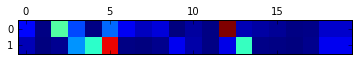

不/限/社保/用药/，/240/万/任性/报销/，/这样/的/防癌/险/买/不/买/？
7 [42964, 2] 防癌/<EOS> 6.5547390377e-05 -9.63274 -9.63274 [-6.6232338, -3.0095031]


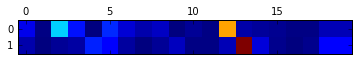

不/限/社保/用药/，/240/万/任性/报销/，/这样/的/防癌/险/买/不/买/？
8 [14211, 14211, 2] 报销/报销/<EOS> 5.87200579359e-05 -9.74273 -9.74273 [-5.9170647, -2.643002, -1.182663]


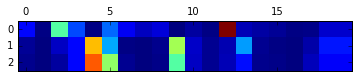

不/限/社保/用药/，/240/万/任性/报销/，/这样/的/防癌/险/买/不/买/？
9 [84, 1059, 14211, 2] 不/限/报销/<EOS> 5.38923656884e-05 -9.82852 -9.82852 [-3.2089024, -1.114854, -4.551496, -0.95326948]


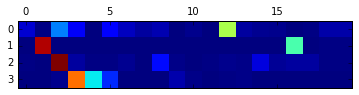

beam search using time(ms): 1772.7560997


In [9]:
#predict(predictor, "宝宝太胖怎么办呢")
#predict(predictor, "包邮买二送一性感女内裤低腰诱惑透视蕾丝露臀大蝴蝶三角内裤女夏-淘宝网")

#predict(predictor, "tensorflow深度学习入门")
#predict(predictor, "大棚辣椒果实变小怎么办,大棚辣椒果实变小防治措施")
inference('上外教口语课能在1个月内提高吗?')
predict(predictor, "土豪邹红建是阿拉斯加")
predict(predictor, "韩国棒球啦啦队员朴姬兰神似刘亦菲")
predict(predictor, '你去打篮球')
predict(predictor, '打篮球你去吗')
predict(predictor, '这是周华健的新歌爱相随')
inference('美女劈叉 鼻血狂喷')
inference('蜀山战纪赵丽颖古装剧照(12张)')
inference('成龙定制豪车领衔 盘点明星们的奢华定制超跑')
inference('年少不懂高晓松,读懂已不再少年')
inference('【图】海贼王污图,海贼王白马觉醒,海贼王白马污')
#inference('男生霸气欧美qq欧美头像_“五花八门”')
inference('美国摄影师拍摄唯美孕妇水下写真艺术照')
inference('精选高清壁纸：孙俪邓超婚纱照')
#inference('周华健')
#inference('江南女子图片下载')
inference('英孚英语 出国难开口？每天充电5分钟，真实旅游场景视频课程')
inference('酷似刘亦菲的朴姬兰')
inference('酷似朴姬兰的刘亦菲')
inference('出国不会说英语？每天5分钟，自信开口说')
inference('河源人凭身份证可以申请贷款，10万月息257元')
inference('学完了这些课程才知道什么叫全能产品经理')
inference('要考雅思了，测测你在考官眼里是啥水平？')
inference('最新消息：高达20万借款，快至30分钟到账，测测你能借多少')
inference('不限社保用药，240万任性报销，这样的防癌险买不买？')